In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import cv2

In [4]:
import tensorflow as tf

Foerst loader vi henvoldsvis et uninficeret og et inficeret billede og plotter dem for at vise de uprocesserede billeder. Det fremgaar her, at billederne har forskellige dimenstioner, og dette goer at det ville vaere svaert at arbejde paa dem uden at ensarte dem.

Text(0.5, 1.0, 'Uninfected cell')

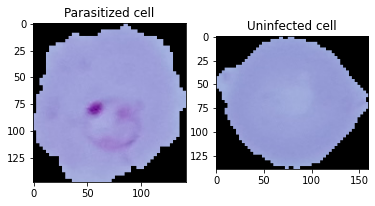

In [6]:
infected_pic = '../img/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'
uninfected_pic = '../img/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_128.png'

plt.subplot(1,2,1)
plt.imshow(cv2.imread(infected_pic))
plt.title('Parasitized cell')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(uninfected_pic))
plt.title('Uninfected cell')


Vi definerer de oenskede dimensioner:

In [8]:
width = 128
height = 128
#vi angiver at settet skal opdeles i test og training folds
data_generator = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)
uninfected_array = cv2.imread(uninfected_pic)


Og her indlaeses training-settet med de oenskede parametre, (der skal eksperimenteres, maaske)

In [10]:
img_dir = '../img/'
train_data_generator = data_generator.flow_from_directory(directory=img_dir, target_size=(width, height), class_mode='binary', batch_size=16, subset='training')

Found 22048 images belonging to 2 classes.


Og valideringssaettet:

In [60]:
test_data_generator = data_generator.flow_from_directory(img_dir, target_size=(width,height), class_mode='binary', batch_size=16, subset='validation', shuffle=False)

Found 5510 images belonging to 2 classes.


Valg af model - noget med cnn i forhold til billeder.
A convolution multiplies a matrix of pixels with a filter matrix or ‘kernel’ and sums up the multiplication values. Then the convolution slides over to the next pixel and repeats the same process until all the image pixels have been covered. This process is visualized below. (For an introduction to deep learning and neural networks, you can refer to my deep learning article here).
https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

<h1> Conv2D </h1>
Conv2D er et convolutional lag, som ved at folde en saakaldt 'kernel' paa hvert element i et billede laver et output i form af en 4D tensor.
<h1> MaxPool2D </h1>
MaxPool2d downscaler inputtet ved at foere et window med den angivne stoerrelse over det 2-dimensionelle data i skridt af stoerrelsen "strides". For hvert stride findes den hoejeste vaerdi i vinduet og dette foejes til output-tensoren.
<h1> Dropout </h1>
Dropout-lag saetter tilfaeldige input-punkter til 0 med en frekvens paa 'rate' under hvert step i traeningen. Dette hjaelper med at forebygge overfitting ved at med et fast interval at indsaette dette 0, sikrer man sig, at modellen ikke proever at fitte til samtlige datapunkter, da nullet typisk vil ligge for langt fra de naerliggende datapunkter og derved kan modellen ikke naa alle. Man kompenserer for dette 'tab' ved at gange de resterende punkter med 1/1-'rate', saa den samlede sum kommer til at vaere den samme.
<h1> Dense </h1>
Dense layer er et af de "hidden layers" der er i et neuralt netværk. Laget bruger samme formler som lineære lag, men har en ikke-lineær aktiveringsfunktion som resultatet bliver ført igennem.
Disse kan stackes (deraf navnet dense layers) for at opnå en højere polynomial grad. Der er en del forskellige aktiveringsfunktionen, dvs. ikke-lineære modeller. Nogle af dem kan ses på billedet herunder;
Begrænsningen i denne type lag ligger i at det samme input altid vil give samme output.
<h1> Flatten </h1>
Flatten() funktionen bliver brugt til at omdanne dataene til noget der kan fodres videre til NN classifieren. I det her tilfælde: dense lagene.
Det den basalt set gør, er at omdanne en matrix til en vektor/array.

In [70]:
from keras.utils.vis_utils import plot_model
model = Sequential()

model.add(Conv2D(16,(3,3),activation='relu',input_shape=(128,128,3)))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.1))

model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))
early_stopping = EarlyStopping(monitor='val_loss', patience=2)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plot_model(model, to_file='model_plot.png', show_layer_names=True, show_shapes=True)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)       

In [16]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16137698494187628727
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12303131035140139489
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10464397888
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17422348598298551005
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9307325069020536579
physical_device_desc: "device: XLA_GPU device"
]


In [18]:
something = model.fit_generator(generator = train_data_generator, steps_per_epoch=len(train_data_generator), epochs=20, validation_data=test_data_generator, validation_steps=len(test_data_generator), callbacks=[early_stopping])



Epoch 1/20
1378/1378 [==============================] - 21s 15ms/step - loss: 0.1307 - accuracy: 0.9605 - val_loss: 0.1763 - val_accuracy: 0.9486
Epoch 2/20
1378/1378 [==============================] - 21s 15ms/step - loss: 0.1265 - accuracy: 0.9601 - val_loss: 0.1865 - val_accuracy: 0.9463
Epoch 3/20
1378/1378 [==============================] - 21s 15ms/step - loss: 0.1282 - accuracy: 0.9597 - val_loss: 0.1598 - val_accuracy: 0.9470
Epoch 4/20
1378/1378 [==============================] - 21s 15ms/step - loss: 0.1262 - accuracy: 0.9614 - val_loss: 0.1552 - val_accuracy: 0.9466
Epoch 5/20
1378/1378 [==============================] - 21s 15ms/step - loss: 0.1258 - accuracy: 0.9615 - val_loss: 0.1557 - val_accuracy: 0.9490
Epoch 6/20
1378/1378 [==============================] - 21s 15ms/step - loss: 0.1202 - accuracy: 0.9622 - val_loss: 0.1709 - val_accuracy: 0.9475


In [20]:
def plotResult(fit, epochs):
    e_range = range(1, epochs+1)
    plt.plot(e_range, fit.history['accuracy'])
    plt.plot(e_range, fit.history['val_accuracy'])
    plt.title('Accuracy of model')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

    plt.plot(e_range, fit.history['loss'])
    plt.plot(e_range, fit.history['val_loss'])
    plt.title('Loss of model')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()


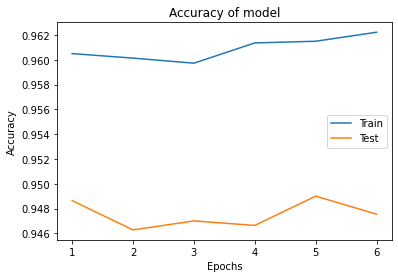

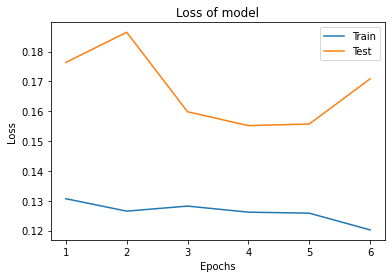

In [22]:
plotResult(something,len(something.epoch))


In [62]:
#y_pred = model.predict(test_data_generator)
#print(y_pred.val_accuracy)
#plt.plot(cv2.imread(train_data_generator[0]))
# from keras import layers
# from kerastuner.tuners import RandomSearch
y_pred = model.predict(test_data_generator, verbose=1, steps=np.ceil(len(test_data_generator)))

# def build_model(hp):
#     model = Sequential()
#     model.add(Conv2D(
#         filters=hp.Choice('filters', values=[8,16,32,64]),
#         kernel_size=hp.Choice('kernel_size',values=[3,2,4]),
#         activation=hp.Choice('activatin',values=['relu', 'sigmoid']), 
#         input_shape=(128,128,3)))

#     model.add(MaxPool2D(pool_size=hp.Choice('pool_size', values=[2,3,4])))

#     model.add(Dropout(rate=hp.Float('rate', min_value=0, max_value=1, step=0.1)))

#     # model.add(Conv2D(16,(3,3),activation='relu'))
#     # model.add(MaxPool2D(2,2))
#     # model.add(Dropout(0.2))

#     # model.add(Conv2D(32,(3,3),activation='relu'))
#     # model.add(MaxPool2D(2,2))
#     # model.add(Dropout(0.3))

#     # model.add(Conv2D(64,(3,3),activation='relu'))
#     # model.add(MaxPool2D(2,2))
#     # model.add(Dropout(0.3))

#     model.add(Flatten())
#     # model.add(Dense(64,activation='relu'))
#     # model.add(Dropout(0.5))

#     # model.add(Dense(1,activation='sigmoid'))
#     # model.compile(optimizer='adam', loss='binary_cross_entropy')
#     model.compile(optimizer='adam',loss='binary_crossentropy', metrics='accuracy')
#     return model

# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=5,
#     executions_per_trial=3
# )

# tuner.search(train_data_generator)


345/345 [==============================] - 4s 13ms/step


In [68]:
y_true_labels = test_data_generator.labels
y_pred_labels = np.round(y_pred)

#for 
# plt.imshow(x[0])
# print(y)